https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns

%matplotlib inline

from scipy import stats
from scipy.stats import norm,skew
from scipy.special import boxcox1p

from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',100)

from tempfile import TemporaryFile

In [2]:
df_train = pd.read_csv('train.csv')

df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df_train.shape

(1460, 81)

In [4]:
df_test = pd.read_csv('test.csv')

df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
df_test.shape

(1459, 80)

In [6]:
df_train.drop('Id',axis = 1,inplace = True)

test_ID = df_test['Id']
df_test.drop('Id',axis = 1,inplace = True)

mu = 180921.20 and sigma = 79415.29


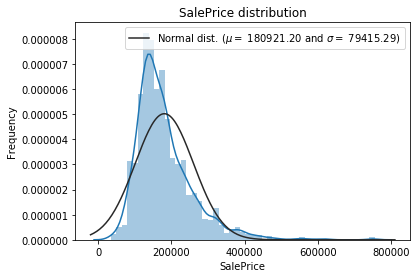

In [7]:
(mu,sigma) = norm.fit(df_train['SalePrice'])
print('mu = {:.2f} and sigma = {:.2f}'.format(mu,sigma))

sns.distplot(df_train['SalePrice'],fit = norm);
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu,sigma)],loc = 'best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution');

In [8]:
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

mu = 12.02 and sigma = 0.40


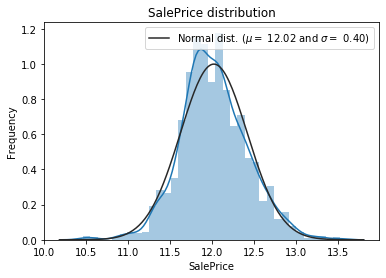

In [9]:
(mu,sigma) = norm.fit(df_train['SalePrice'])
print('mu = {:.2f} and sigma = {:.2f}'.format(mu,sigma))

sns.distplot(df_train['SalePrice'],fit = norm);
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu,sigma)],loc = 'best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution');

In [10]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]

df_y = df_train['SalePrice']

df_all_data = pd.concat([df_train,df_test]).reset_index(drop = True)
df_all_data.drop(['SalePrice'],axis = 1,inplace = True)

df_all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,GLQ,Unf,1.0,0.0,Gd,150.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,NaN,0,PConc,2,Typ,548.0,2.0,TA,RFn,TA,Attchd,2003.0,1710,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,8450,Inside,65.0,Reg,0,60,RL,196.0,BrkFace,NaN,0,2,CollgCr,61,5,7,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,ALQ,Unf,0.0,1.0,Gd,284.0,Y,Feedr,Norm,SBrkr,0,TA,TA,MetalSd,MetalSd,NaN,TA,1,CBlock,2,Typ,460.0,2.0,TA,RFn,TA,Attchd,1976.0,1262,0,GasA,Ex,1Story,1,TA,Lvl,Gtl,9600,FR2,80.0,Reg,0,20,RL,0.0,None,NaN,0,5,Veenker,0,8,6,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,GLQ,Unf,1.0,0.0,Gd,434.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,TA,1,PConc,2,Typ,608.0,2.0,TA,RFn,TA,Attchd,2001.0,1786,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,11250,Inside,68.0,IR1,0,60,RL,162.0,BrkFace,NaN,0,9,CollgCr,42,5,7,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,ALQ,Unf,1.0,0.0,TA,540.0,Y,Norm,Norm,SBrkr,272,TA,TA,Wd Sdng,Wd Shng,NaN,Gd,1,BrkTil,1,Typ,642.0,3.0,TA,Unf,TA,Detchd,1998.0,1717,0,GasA,Gd,2Story,1,Gd,Lvl,Gtl,9550,Corner,60.0,IR1,0,70,RL,0.0,None,NaN,0,2,Crawfor,35,5,7,Y,0,NaN,CompShg,Gable,Abnorml,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,GLQ,Unf,1.0,0.0,Gd,490.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,TA,1,PConc,2,Typ,836.0,3.0,TA,RFn,TA,Attchd,2000.0,2198,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,14260,FR2,84.0,IR1,0,60,RL,350.0,BrkFace,NaN,0,12,NoRidge,84,5,8,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [11]:
df_all_data.shape

(2919, 79)

In [12]:
total = df_all_data.isnull().sum().sort_values(ascending = False)
percent = ((df_all_data.isnull().sum() / len(df_all_data)).sort_values(ascending = False)) * 100

df_missing_data = pd.concat([total,percent],axis = 1,keys = ['Total','Percent'])

df_missing_data.head(35)

,Total,Percent
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageFinish,159,5.447071
GarageQual,159,5.447071
GarageYrBlt,159,5.447071
GarageCond,159,5.447071


In [13]:
df_all_data['PoolQC'] = df_all_data['PoolQC'].fillna('None')

In [14]:
df_all_data['MiscFeature'] = df_all_data['MiscFeature'].fillna('None')

In [15]:
df_all_data['Alley'] = df_all_data['Alley'].fillna('None')

In [16]:
df_all_data['Fence'] = df_all_data['Fence'].fillna('None')

In [17]:
df_all_data['FireplaceQu'] = df_all_data['FireplaceQu'].fillna('None')

In [18]:
df_all_data['MasVnrType'] = df_all_data['MasVnrType'].fillna('None')

In [19]:
df_all_data['MasVnrArea'] = df_all_data['MasVnrArea'].fillna(0)

In [20]:
df_all_data['Functional'] = df_all_data['Functional'].fillna('Typ')

In [21]:
df_all_data['MSZoning'] = df_all_data['MSZoning'].fillna(df_all_data['MSZoning'].mode()[0])

In [22]:
df_all_data['Electrical'] = df_all_data['Electrical'].fillna(df_all_data['Electrical'].mode()[0])

In [23]:
df_all_data['KitchenQual'] = df_all_data['KitchenQual'].fillna(df_all_data['KitchenQual'].mode()[0])

In [24]:
df_all_data['Exterior1st'] = df_all_data['Exterior1st'].fillna(df_all_data['Exterior1st'].mode()[0])

In [25]:
df_all_data['Exterior2nd'] = df_all_data['Exterior2nd'].fillna(df_all_data['Exterior2nd'].mode()[0])

In [26]:
df_all_data['LotFrontage'] = df_all_data.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [27]:
df_all_data['SaleType'] = df_all_data['SaleType'].fillna(df_all_data['SaleType'].mode()[0])

In [28]:
df_all_data['MSSubClass'] = df_all_data['MSSubClass'].fillna('None')

In [29]:
for col in ('GarageType','GarageFinish','GarageQual','GarageCond'):
    df_all_data[col] = df_all_data[col].fillna('None')

In [30]:
for col in ('GarageYrBlt','GarageArea','GarageCars'):
    df_all_data[col] = df_all_data[col].fillna(0)

In [31]:
for col in ('BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath'):
    df_all_data[col] = df_all_data[col].fillna(0)

In [32]:
for col in ('BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'):
    df_all_data[col] = df_all_data[col].fillna('None')

In [33]:
df_all_data = df_all_data.drop(['Utilities'],axis = 1)

In [34]:
total = df_all_data.isnull().sum().sort_values(ascending = False)
percent = ((df_all_data.isnull().sum() / len(df_all_data)).sort_values(ascending = False)) * 100

df_missing_data = pd.concat([total,percent],axis = 1,keys = ['Total','Percent'])

df_missing_data.head()

,Total,Percent
YrSold,0,0.0
Foundation,0,0.0
ExterCond,0,0.0
ExterQual,0,0.0
Exterior1st,0,0.0


In [35]:
df_all_data['MSSubClass'] = df_all_data['MSSubClass'].apply(str)

In [36]:
df_all_data['OverallCond'] = df_all_data['OverallCond'].astype(str)

In [37]:
df_all_data['YrSold'] = df_all_data['YrSold'].astype(str)

In [38]:
df_all_data['MoSold'] = df_all_data['MoSold'].astype(str)

In [39]:
cols = ('FireplaceQu','BsmtQual','BsmtCond','GarageQual','GarageCond','ExterQual','ExterCond','HeatingQC',
        'PoolQC','KitchenQual','BsmtFinType1','BsmtFinType2','Functional','Fence','BsmtExposure','GarageFinish',
        'LandSlope','LotShape','PavedDrive','Street','Alley','CentralAir','MSSubClass','OverallCond','YrSold','MoSold')

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df_all_data[c].values)) 
    df_all_data[c] = lbl.transform(list(df_all_data[c].values))

In [40]:
df_all_data['TotalSF'] = df_all_data['TotalBsmtSF'] + df_all_data['1stFlrSF'] + df_all_data['2ndFlrSF']

In [41]:
numeric_feats = df_all_data.dtypes[df_all_data.dtypes != 'object'].index

skewed_feats = df_all_data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending = False)
skewness = pd.DataFrame({'Skew':skewed_feats})

skewness.head()

,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065


In [42]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15

for feat in skewed_features:
    df_all_data[feat] = boxcox1p(df_all_data[feat],lam)

There are 59 skewed numerical features to Box Cox transform


In [49]:
numeric_feats = df_all_data.dtypes[df_all_data.dtypes != 'object'].index

skewed_feats = df_all_data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending = False)
skewness = pd.DataFrame({'Skew':skewed_feats})

skewness.head()

,Skew
Exterior1st_ImStucc,54.000003
RoofMatl_Membran,54.000003
Condition2_RRAn,54.000003
MiscFeature_TenC,54.000003
RoofMatl_ClyTile,54.000003


In [43]:
df_all_data.shape

(2919, 79)

In [44]:
df_all_data = pd.get_dummies(df_all_data)

In [45]:
df_all_data.shape

(2919, 221)

In [46]:
df_train = df_all_data[:ntrain]
df_test = df_all_data[ntrain:]

In [47]:
model_lr = linear_model.LinearRegression()
model_lr.fit(df_train,df_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [48]:
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = model_lr.predict(df_test)
submission.to_csv('submission.csv',index = False)